In [1]:
from importlib.metadata import version
print("torch version:", version("torch"))

torch version: 2.1.2


#### Stage 1 - **Building a LLM** 
1. Data preparation & sampling
2. ***Attention mechanism*** <----------------
3. LLM architecture

4. Pretraining

#### Stage 2 - **Foundation model**
5. Training loop 
6. Model evaluation
7. Load pretrained weights

8. Finetuning  -> dataset with class labels - classifier
              |-> instruction dataset - personal assistant



1. Simplified self-attention: A simplified self-attention technique to introduce the broader idea.
2. Self - attention: Self-attention with trainable weights that form the basis of the mechanism used in LLMs.
3. Causal attention: A type of self-attention used in LLMs that allows a model to consider only previous and current inputs in a sequence, ensuring temporal order during the text generation.
4. Multi-head attention: An extension of self-attention and casual attention that enables the model to simultaneously attend to info from different rep subspaces.

#### **Problem with modeling long sequence**
- Translating a text word by word isn't feasible due to the difference in grammatical structures between the souce and target languages

- The encoder processes a sequence of tokens from the source language, using a hidden state-- a kind of intermediate layer within the neural network -- to generate a condensed representation of the entire input sequence.
- Through an attention mechanism, the text-generating decoder segment of the network is capable of selectively accessing all the input tokens, implying that certain input tokens hold more significance than others in the generation of specific output token
- Self-attention in transformers is a technique designed to enhance input representations by enabling each position in a sequence to engage with and determine the relevance of every other position within the same sequence.


### Attending to different parts of the input with self-attention

#### Simple attention mechanism
- Suppose an input sequence x(1) to x(T), x(1) is a d-dimensional vector rep



In [47]:
# input seq that is embedded in 3-demensional vector

import torch 
inputs = torch.tensor([[0.43, 0.15, 0.89],    #Your
                       [0.55, 0.87, 0.66],          #journey
                       [0.57, 0.85, 0.64],    #Starts
                       [0.22, 0.58, 0.33],    #with
                       [0.77, 0.25, 0.10],    #one
                       [0.05, 0.80, 0.55]])   #step

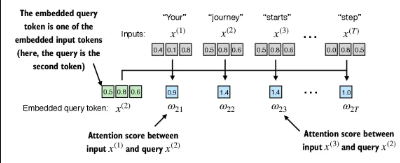

tensor([8.7767e-11, 2.0669e-42, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])

In [5]:
query = inputs[1]

attn_scores_2 = torch.empty(inputs.shape[0])    #intiating an empty array

for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query)

print(attn_scores_2) 

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


### **step 2 normalize the attenton score**

In [4]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()

print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())


Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)


- however, in practice, using the softmax function for normalization, which is better at handling extreme values and has more desirable gradient properties during training, is common and recommended
- 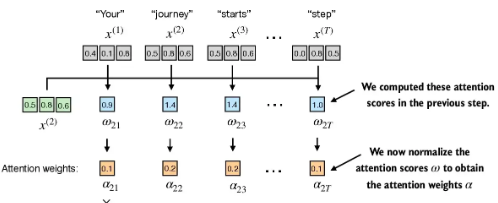

In [5]:
#naive implementation for softmax function
def softmax_func(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_softmax = softmax_func(attn_scores_2)

print("Attention weights:", attn_weights_2_softmax)
print("Sum:", attn_weights_2_softmax.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


- naive implementaion above can suffer from numerical instability issues for large or small input values due to overflow and underflow issues.
- In practice, its recommended to use the PyTorch implementation of softmax instead, which has been highly optimized for performance:

In [13]:
attn_weights_2 = torch.softmax(attn_scores_2, dim = 0)

print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


### **step 3: compute the context vector z(2)**
- by multipling the embedded input tokens, x(i) with the attention weights and sum the resulting vectors
- 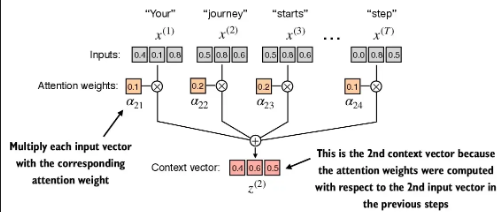

In [14]:
context_vec_2 = torch.zeros(query.shape)

for i, x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i]*x_i

print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


### Computing attention weights for all input tokens
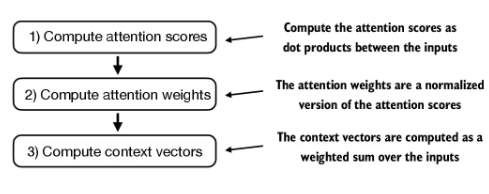

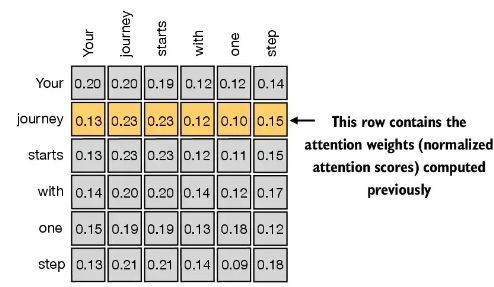

In [15]:
attn_scores = torch.empty(6,6)

for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i,j] = torch.dot(x_i, x_j)

print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [16]:
# We can achieve the same as above more efficiently via matrix multiplication

attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [17]:
#step 2 - normalize each row so that the values in each row sum to 1

attn_weights = torch.softmax(attn_scores, dim = -1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [18]:
row_2_sum = sum([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
print("Row 2 sum:", row_2_sum)

print("all row sums:", attn_weights.sum(dim=-1))

Row 2 sum: 1.0
all row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [19]:
#step 3  6*6  6*3

all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


### **3.4 Implementing self-attention with trainable weights**

#### 3.4.1
- self attention mechanism implementation.
- also called scaled dot-product attention.
- we want to compute context vector as weighted sums over the input vectors specific to certain input elements.
  - attention weights for the above
- slightly differences compared to the basic attention mechanism.
  - notable difference is the introduction of weight matrices that are updated during model training.
  - trainable weights matrices are crucial so that the model can learn to produce "good" context vectors.

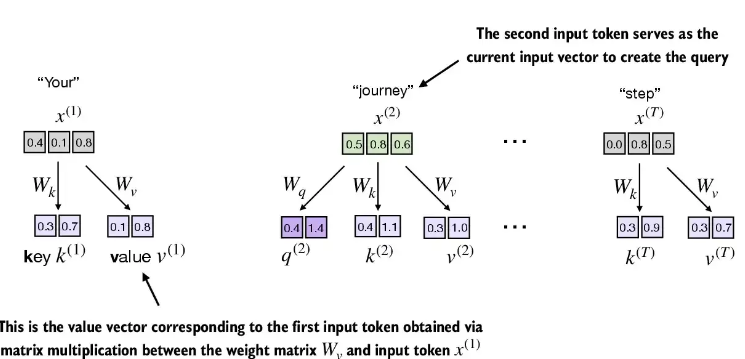
- implementing the self-attention mechanism step by step, we will start by introducing the three training weight matrcies $W_q$, $W_k$, $W_v$
- These three matrics are used to project the embedded input tokens, $x^{(i)}$,
into query, key, value vectors via matrix multiplication:
  - Query vector: $q^{(i)} = W_q \,x^{(i)}$
  - Key vector: $k^{(i)} = W_k \,x^{(i)}$
  - Value vector: $v^{(i)} = W_v \,x^{(i)}$


In [20]:
x_2 = inputs[1] #second input element
d_in = inputs.shape[1] #input embedding size, d=3
d_out = 2 #output embedding size, d = 2

* Below, we initialize the three weights matrics; note that we are setting `requires_grad = False` to reduce clutter in the outputs for illustration purpose, 
but if we were to use the weight matrices for model training, we  would set `reuqires_grad = True` cto update these matrcis during model training.

In [21]:
torch.manual_seed(123)

W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key   = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value   = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

In [22]:
query_2 = x_2 @ W_query
key_2   = x_2 @ W_key
value_2 = x_2 @ W_value

print(query_2)

tensor([0.4306, 1.4551])


In [23]:
keys   = inputs @ W_key
values = inputs @ W_value

print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


In [24]:
inputs.shape, keys.shape

(torch.Size([6, 3]), torch.Size([6, 2]))

- As we can see below, we successfully projected the 6 inputs tokens from a 3D onto a 2D embedding space

- In the next step, step-2, we compute the unnormalized attention scores by computing the dot product between the query and each key vector
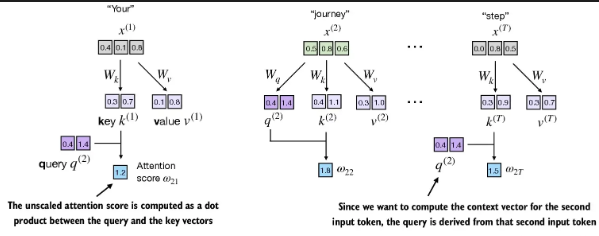

In [25]:
keys_2 = keys[1]
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22)

tensor(1.8524)


In [26]:
# Since we have 6 inputs, we have 6 attention scores for the given query vector

attn_scores_2 = query_2 @ keys.T
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


- next step-3, we compute the attention weights (normalized attention scores that sum up to 1) using the softmax function we used earlier.
- the difference to earlier is that we now scale the attention scores by diving them by the square root of the embedding dimension $\sqrt{d_k}$
- 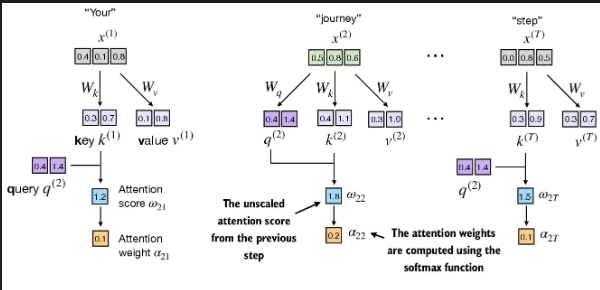

In [27]:
d_k = keys.shape[1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
print(attn_weights_2)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


- step 4, we now compute the context vector for input query vector 2. 
- 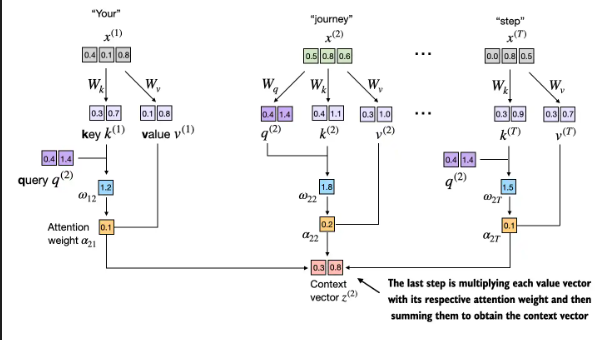

In [28]:
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.3061, 0.8210])


### Impletmenting a compact SelfAttention class
- Putting it all together, we can implement the self-attention mechanism as follows.


In [29]:
import torch.nn as nn 

class SelfAttention_v1(nn.Module):

    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key   = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        keys    = x @ self.W_key
        queries = x @ self.W_query
        values  = x @ self.W_value
        
        attn_scores  = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim = 1)

        context_vec =attn_weights @ values
        return context_vec

In [30]:
torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1.forward(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


In [31]:
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


- 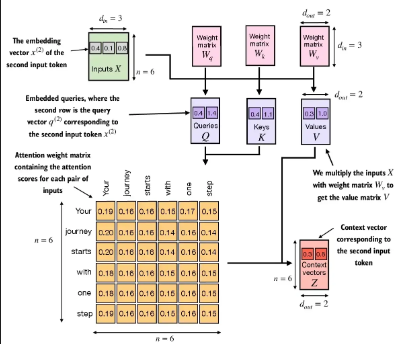

- We can steamline the implementation above using PyTorch linear layers, which are equvivalent to a matrix multiplication if we disable the bias unit
- Another big advantave of using nn.Linear over out manial nn.Parameter(torch.rand()) approach is that nn.Linear has a preferred weight initialization scheme, which leads to more stable model training.

In [32]:
class SelfAttention_v2(nn.Module):

    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        
        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        context_vec = attn_weights @ values
        return context_vec

torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


- Note that SelfAttention_v1 , SelfAttention_v2 give different outputs because they use different initial weights for the weight matrices

### Hiding future words with casual attention

- In casual attention, the attention weights above the diagonal are masked, ensuring that for any given input, the LLM is unable to utilize future tokens while calculating the context vectors with the atttention weights
- 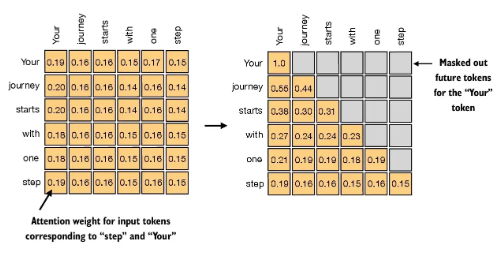

- In this section, we are converting the previous self-attention mechnism into a casual self-attention mechanism.
- Casual Self-attention ensures that the model's prediction for a certain postion in the sequence is only dependent on the know outputs at the previous position, not on future positions.
- In simpler words, this enusures that each next word prediction should only depend on the preceding words.
- To achieve this, for each given token, we mask out the future tokens (the ones that come after the current token in the input text).
- 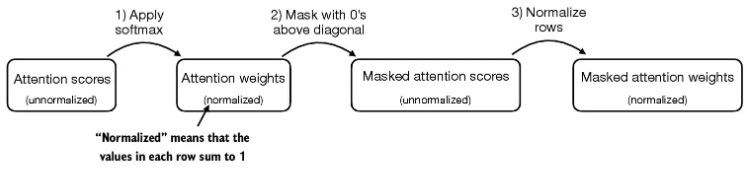


In [35]:
queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs)

attn_scores = queries @ keys.T 

attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim = -1)
print(attn_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


In [36]:
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [38]:
masked_simple = attn_weights*mask_simple
print(masked_simple)

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)


- However, if the `mask were applied after softmax`, like above it, it would `disrupt the probability distribution created by softmax`.
- Softmax ensures that all output values sum to 1.
- Masking after softmax would require re-normalising the outputs to sum to 1 again, which complicates the process and might lead to unintended effects
- To make sure that the row sum to 1, we can normalize the attention weights as follows:

In [39]:
row_sums = masked_simple.sum(dim = -1, keepdim=True)
masked_simple_norm = masked_simple / row_sums

print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)


- While we are technically done with coding the casual attention mechanism now, lwts briefly look at a more efficient approach to achieve the same as above.
- So, instead of zeroing out attention weights above the diagonal and renormalizing the results, we can mask the unnormalized attention scores above the diagonal with negatively before they enter the softmax funtion.
- 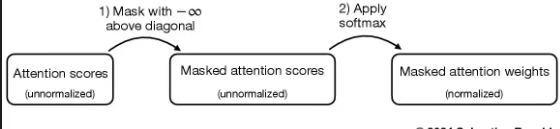

In [41]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal = 1)
masked =attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


In [42]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim = -1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


### Masking additional attention weights with dropout

- In addition, we also apply dropout to reduce overfitting during training.
- Dropout can be application in several places:
  - for example, after computing the attention weights;
  - or after multiplying the attention weights with the value vectors.
- Here, we will apply the dropout mask after computing the attention weights because its more common
- furthermore, in this specific example, we use a dropout rate of 50%, which means randomly masking out half of the attention weigths.( When we train the GPT model later, we will use a lower dropout rate, such as 0.1 or 0.2)
- 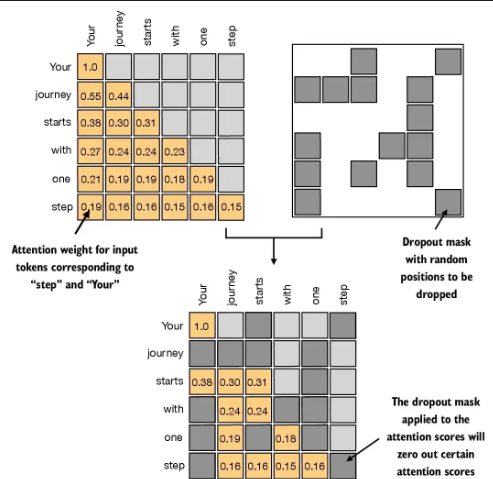
- Dropout is only applied during training, not during inference

In [44]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5)
example = torch.ones(6,6)

print(dropout(example))

tensor([[2., 2., 2., 2., 2., 2.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 2., 0.],
        [2., 2., 0., 0., 0., 2.],
        [2., 0., 0., 0., 0., 2.],
        [0., 2., 0., 0., 0., 0.]])


In [45]:
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4921, 0.0000, 0.4638, 0.0000, 0.0000],
        [0.0000, 0.3966, 0.3968, 0.3775, 0.3941, 0.0000],
        [0.3869, 0.3327, 0.0000, 0.0000, 0.3331, 0.3058]],
       grad_fn=<MulBackward0>)


### Implementing a compact casual self-attention class
- Now, we are ready to implement a working implementation of self-attention, including the casual and dropout masks.
- One more thing is to implement the code to handle batches consisting of more than one input so that out CasualAttention class supports the batch outputs produced by dataloader we implemented in chapter 2
- For simplicity, to simulate such batch input, we duplicate the input text example

In [48]:
batch = torch.stack((inputs, inputs), dim =0)
print(batch.shape), print(batch)

torch.Size([2, 6, 3])
tensor([[[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]],

        [[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]]])


(None, None)

In [51]:
class CausalAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias= False):
        super().__init__()
        self.d_out   = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys    = self.W_key(x)
        queries = self.W_query(x)
        values  = self.W_value(x)

        attn_scores  = queries @ keys.transpose(1,2)
        attn_scores.masked_fill_(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = attn_weights @ values
        
        return context_vec        

In [52]:
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)

context_vecs = ca.forward(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]],

        [[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]]], grad_fn=<UnsafeViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


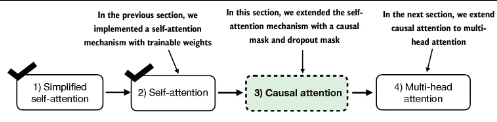

### Extending single-head attention to multihead attention
- Summary of the self-attention implemented previously (casual and dropout masks not shown for simplicity)
- Also called Single-head attention.
- 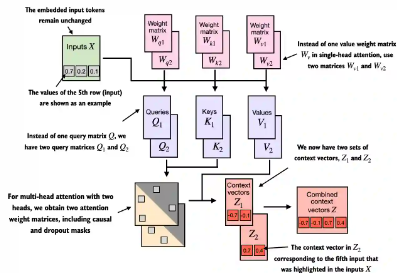


- We  simply stack multiple single-head attention modules to obtain a multihead attention module:
- - 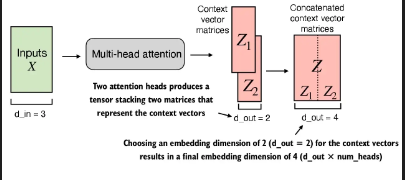
- The main idea behind multihead attention is to run the attention mechanism multiple times with different, learned linear projections. This allows the model to jointly attend to information from different representation subspaces at different positions.

In [61]:
class MultiHeadAttentionWrapper(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias = False):
        super().__init__()
        self.heads= nn.ModuleList(
            [CausalAttention(d_in, d_out, context_length, dropout, qkv_bias) 
             for _ in range(num_heads)]
            )
    
    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim = -1)

In [62]:
torch.manual_seed(123)

context_length = batch.shape[1]
d_in, d_out = 3,2
mha = MultiHeadAttentionWrapper(d_in, d_out, context_length, 0.0, num_heads=2)

context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape", context_vecs.shape)

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
context_vecs.shape torch.Size([2, 6, 4])


- in the implementation above, the embedding dimension is 4, because we` d_out = 2 `as the embedding dimension for the key, query and value vectors as well as the context vectors. And since we have ``2 attention heads``, we have the output embedding dimension `2*2 = 4`

### Implementing multi-head attention with weight splits
- While the above is an intuitive and fully functional implementation of multi-head attention(wrapping the single-head attention CausalAttention implementation from earlier),  we can write a stand-alone class called MultiHeadAttention to achieve the same
- We don't concatenate single attention heads for this stand-alone MultiHeadAttention class.
- Instead, we create single W_query, W_key and W_value weight matrices and then split those into individual matrices for each attention head:

In [64]:
##############################     COPY PASTED     ##########################
##############################   Need To Revisit   ##########################

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

torch.manual_seed(123)

batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)

context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


- Note that the above is essentially a rewritten version of MultiHeadAttentionWrapper that is more efficient.
- The result output looks a bit different since the random weight initializations differ, but both are fully functional implementations that can be used in the GPT class we will implement in the upcoming chapeters.
- Note that in addition, we added a linear projection layer (`self.out_proj `) to the `MultiHeadAttention` class above. This is simply a linear transformation that doesn't change the dimensions. It's a standard convention to use such a projection layer in LLM implementation, but it's not strictly necessary (recent research has shown that it can be removed without affecting the modeling performance; see the further reading section at the end of this chapter)


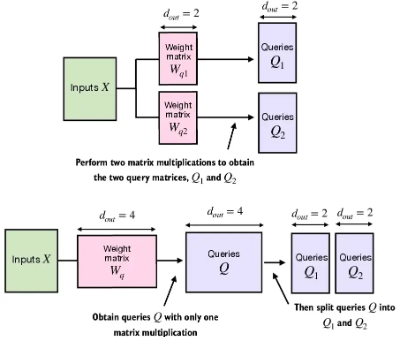